In [3]:
from typing import Dict, Iterable, Optional

import numpy as np
import torch
from torch.distributions import Normal, Poisson
from torch.distributions import kl_divergence as kld
from torch import tensor
from complementary_models import HALOMASKVIR as HALOVI
from complementary_models import HALOMASKVAE as HALOVAE
import scanpy as sc
import scvi

import pandas as pd
# torch.autograd.set_detect_anomaly(True)

Global seed set to 0


In [4]:
### test whole data with RNA only 
path = "/mnt/data0/halo/multivelo_BM/ATAC/multivelo_bonemarrow.h5ad"
adata_multi = sc.read_h5ad(path)
adata_multi.obs["batch_id"] = 1
adata_multi.var["modality"] =adata_multi.var["feature_types"]
adata_mvi = scvi.data.organize_multiome_anndatas(adata_multi)
sc.pp.filter_genes(adata_mvi, min_cells=int(adata_mvi.shape[0] * 0.01))

In [5]:
# variables for subsetting the AnnData object to just the myeloid lineage


hsc_check = adata_mvi.obs['leiden'] == "HSC"
mpp_check = adata_mvi.obs['leiden'] == "MPP"
lmpp_check = adata_mvi.obs['leiden'] == "LMPP"
gmp_check = adata_mvi.obs['leiden'] == "GMP"

myeloid_check = (hsc_check | mpp_check | lmpp_check | gmp_check)
adata_mvi = adata_mvi[myeloid_check, :].copy()


In [6]:
HALOVI.setup_anndata(adata_mvi, batch_key="modality", time_key='latent_time')
model = HALOVI(
    adata_mvi,
    n_genes=(adata_mvi.var['modality']=='Gene Expression').sum(),
    n_regions=(adata_mvi.var['modality']=='Peaks').sum()
)

n_genes :15539
fine tune is False
gate decoder initialization n_input 10, n_output 175185,         n_hidden_local 20, n_hidden_global 128, n_cat_list [1], *cat_list 1


In [7]:
## load pre-trained models
model = model.load("model_multivelo_fig5_causal_01_softmax", adata_mvi)
# model = model.load("model_multivelo_data_nocausal", adata_mvi)

# model = model.load("model_multivelo_fig5_nocausal", adata_mvi)

# model = model.load("model_multivelo_fig5_causal_0065_softmax", adata_mvi)
# model = model.load("model_myeloid_data_nocausal", adata_mvi)

INFO     File model_multivelo_fig5_causal_01_softmax/model.pt already downloaded             
n_genes :15539
fine tune is False
gate decoder initialization n_input 10, n_output 175185,         n_hidden_local 20, n_hidden_global 128, n_cat_list [1], *cat_list 1


In [11]:
model.module.set_finetune_params(0)
model.module.set_train_params(expr_train=True, acc_train=True)
model.train(max_epochs=800, batch_size=512)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 278/800:  35%|███▍      | 277/800 [49:01<1:33:41, 10.75s/it, loss=2.8e+05, v_num=1] 

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [18]:
# model.save("model_myeloid_data_nocausal",overwrite=True)
model.save("model_multivelo_data_nocausal",overwrite=True)

In [6]:
model.module.alpha = 0.02
model.module.beta_2 = 1e7
model.module.beta_3 = 1e8
model.module.beta_1 = 1e7
print(model.module.alpha)

0.1


In [7]:
## finetune without L0
# model.module.alpha = 0.06
model.module.set_finetune_params(2)
model.module.set_train_params(expr_train=True, acc_train=True)
model.plan_kwargs = {"n_epochs_kl_warmup":300}
model.train(max_epochs=600, batch_size=512)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 224/600:  37%|███▋      | 223/600 [25:43<44:15,  7.04s/it, loss=1.04e+06, v_num=1]

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [27]:
adata_mvi

AnnData object with n_obs × n_vars = 11605 × 190724
    obs: 'n_counts', 'n_genes_by_counts', 'total_counts', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'S_score', 'G2M_score', 'phase', 'fraction_u', 'leiden', 'root_prediction', 'total_s', 'total_u', 'total_Ms', 'total_Mu', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time', 'batch_id', 'modality', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'feature_types', 'modality', 'n_cells'
    uns: '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap', 'leiden_colors'
    obsm: 'latent', 'X_umap'
    obsp: 'distances', 'connectivities'

In [34]:
model.save("model_myeloid_data_causal01",overwrite=True)

In [7]:
model.save("model_multivelo_data_causal01",overwrite=True)

In [123]:
model.save("model_multivelo_fig5_causal_01_softmax", overwrite=True)

In [6]:
model = model.load("model_neural_BM_mouse_causal_0065_softmax",adata_mvi)

INFO     File model_neural_BM_mouse_causal_0065_softmax/model.pt already downloaded          
n_genes :14583
fine tune is False
gate decoder initialization n_input 10, n_output 123883,         n_hidden_local 20, n_hidden_global 128, n_cat_list [1], *cat_list 1


In [9]:
latent_expr, latent_acc,latent_expr_dep, latent_atac_dep, latent_expr_indep, latent_atac_indep, times  = model.get_latent_representation()

In [9]:
from complementary_models import torch_infer_nonsta_dir


latent_atac_indep_t = torch.tensor(latent_atac_indep).to('cuda')
latent_expr_indep_t = torch.tensor(latent_expr_indep).to('cuda')
times = torch.tensor(times).to('cuda')
# times = np.array(times.detach().cpu())
score3 = []
score4=[]

cells = latent_expr.shape[0]
locals = 1500
iterations = int(cells / locals)

for i in range(iterations):
    if i==iterations-1:
        score3.append(torch_infer_nonsta_dir(latent_atac_indep_t[i*locals:,:], latent_expr_indep_t[i*locals:,:], times[i*locals:])[0].detach().cpu())
        score4.append(torch_infer_nonsta_dir(latent_expr_indep_t[i*locals:,:], latent_atac_indep_t[i*locals:,:], times[i*locals:])[0].detach().cpu())
    else:

        score3.append(torch_infer_nonsta_dir(latent_atac_indep_t[i*locals:(i+1)*locals,:], latent_expr_indep_t[i*locals:(i+1)*locals,:], times[i*locals:(i+1)*locals])[0].detach().cpu())
        score4.append(torch_infer_nonsta_dir(latent_expr_indep_t[i*locals:(i+1)*locals,:], latent_atac_indep_t[i*locals:(i+1)*locals,:], times[i*locals:(i+1)*locals])[0].detach().cpu())

# for i in range(iterations):
#         choices = np.random.choice(cells, locals)
#         score3.append(torch_infer_nonsta_dir(latent_atac_indep_t[choices,:], latent_expr_indep_t[choices:], times[choices])[0].detach().cpu())
#         score4.append(torch_infer_nonsta_dir(latent_expr_indep_t[choices,:], latent_atac_indep_t[choices,:], times[choices])[0].detach().cpu())

# print("score3 {} and score4 {}".format(score3, score4))

score3 = np.mean(np.array(score3))
score4 = np.mean(np.array(score4))


# score3, _, _ = infer_nonsta_dir(latent_atac_indep[:5000,:], latent_expr_indep[:5000, :], times[:5000])
# score3
# score4, _, _ = infer_nonsta_dir(latent_expr_indep[:5000,:], latent_atac_indep[:5000,:], times[:5000])
print("score3 {} and score4 {}".format(score3, score4))
score3 - score4

score3 0.0668522966447755 and score4 0.0686875176562516


-0.0018352210114760958

In [10]:
from complementary_models import torch_infer_nonsta_dir
from complementary_models import infer_nonsta_dir


latent_atac_dep_t = torch.tensor(latent_atac_dep).to('cuda')
latent_expr_dep_t = torch.tensor(latent_expr_dep).to('cuda')
# times = torch.tensor(times).to('cuda')
# times = np.array(times.detach().cpu())
score1 = []
score2=[]

cells = latent_expr.shape[0]
locals = 1000
iterations = int(cells / locals)

for i in range(iterations):
    if i==iterations-1:
        score1.append(torch_infer_nonsta_dir(latent_atac_dep_t[i*locals:,:], latent_expr_dep_t[i*locals:,:], times[i*locals:])[0].detach().cpu())
        score2.append(torch_infer_nonsta_dir(latent_expr_dep_t[i*locals:,:], latent_atac_dep_t[i*locals:,:], times[i*locals:])[0].detach().cpu())
    else:

        score1.append(torch_infer_nonsta_dir(latent_atac_dep_t[i*locals:(i+1)*locals,:], latent_expr_dep_t[i*locals:(i+1)*locals,:], times[i*locals:(i+1)*locals])[0].detach().cpu())
        score2.append(torch_infer_nonsta_dir(latent_expr_dep_t[i*locals:(i+1)*locals,:], latent_atac_dep_t[i*locals:(i+1)*locals,:], times[i*locals:(i+1)*locals])[0].detach().cpu())


score1 = np.mean(np.array(score1))
score2 = np.mean(np.array(score2))


# score3, _, _ = infer_nonsta_dir(latent_atac_indep[:5000,:], latent_expr_indep[:5000, :], times[:5000])
# score3
# score4, _, _ = infer_nonsta_dir(latent_expr_indep[:5000,:], latent_atac_indep[:5000,:], times[:5000])
print("score1 {} and score2 {}".format(score1, score2))


score1 0.07796180006636048 and score2 0.06688711293322978


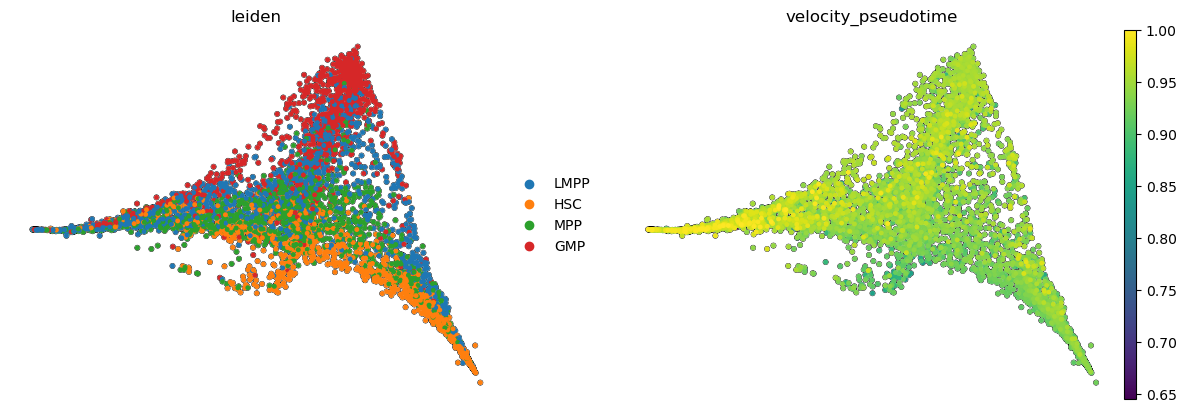

In [45]:
adata_mvi.obsm["latent"] = latent_expr
sc.pp.neighbors(adata_mvi, use_rep = 'latent', metric = 'manhattan')
sc.tl.umap(adata_mvi, min_dist=0.1, negative_sample_rate=0.05)

sc.pl.umap(adata_mvi, frameon=False, size = 50, alpha = 1, add_outline=True,
          outline_width=(0.1,0), color=['leiden', "velocity_pseudotime"])

In [44]:
adata_mvi.obs

n_counts  n_genes_by_counts  total_counts  \
AAACATGCAGAGGCTA-1_paired  4260.723633               1572        3526.0   
AAACATGCAGGAACCA-1_paired  4273.575195               1308        2563.0   
AAACATGCAGGTTATT-1_paired  4233.078125               1688        3177.0   
AAACATGCAGTATGTT-1_paired  4256.907715               1784        4137.0   
AAACCAACAGCATGAG-1_paired  4279.204102               2439        6561.0   
...                                ...                ...           ...   
TTTGTGTTCGGGCCAT-1_paired  4250.009766               2732        7504.0   
TTTGTTGGTATTTGCC-1_paired  4258.036133               2157        4704.0   
TTTGTTGGTGCTGGTG-1_paired  4237.927246               2398        5328.0   
TTTGTTGGTGTTAAAC-1_paired  4227.182129               1642        3244.0   
TTTGTTGGTTGCCTCA-1_paired  4247.338379               1805        3814.0   

                           initial_size_spliced  initial_size_unspliced  \
AAACATGCAGAGGCTA-1_paired                  3495                    1683   
AAACATGCAGGAACCA-1_paired                  2529                    2512   
AAACATGCAGGTTATT-1_paired                  3133                    1861   
AAACATGCAGTATGTT-1_paired                  4090                    1715   
AAACCAACAGCATGAG-1_paired                  6503                    1858   
...                                         ...                     ...   
TTTGTGTTCGGGCCAT-1_paired                  7441                    2950   
TTTGTTGGTATTTGCC-1_paired                  4649                    2471   
TTTGTTGGTGCTGGTG-1_paired                  5242                    3300   
TTTGTTGGTGTTAAAC-1_paired                  3198                    1635   
TTTGTTGGTTGCCTCA-1_paired                  3775                    2367   

                           initial_size   S_score  G2M_score phase  \
AAACATGCAGAGGCTA-1_paired        3495.0  0.403889  -0.431673     S   
AAACATGCAGGAACCA-1_paired        2529.0 -0.244915  -0.137859    G1   
AAACATGCAGGTTATT-1_paired        3133.0 -1.759865   0.094143   G2M   
AAACATGCAGTATGTT-1_paired        4090.0  0.000000  -0.203262     S   
AAACCAACAGCATGAG-1_paired        6503.0 -0.168407  -0.124096    G1   
...                                 ...       ...        ...   ...   
TTTGTGTTCGGGCCAT-1_paired        7441.0  0.156896   0.377860   G2M   
TTTGTTGGTATTTGCC-1_paired        4649.0  0.000000  -0.087100     S   
TTTGTTGGTGCTGGTG-1_paired        5242.0 -0.731021   0.004570   G2M   
TTTGTTGGTGTTAAAC-1_paired        3198.0 -0.656418  -0.192740    G1   
TTTGTTGGTTGCCTCA-1_paired        3775.0  1.194364  -0.119897     S   

                           fraction_u  ...    total_Mu  \
AAACATGCAGAGGCTA-1_paired    0.378415  ...  206.011414   
AAACATGCAGGAACCA-1_paired    0.336668  ...  225.887848   
AAACATGCAGGTTATT-1_paired    0.411773  ...  226.239594   
AAACATGCAGTATGTT-1_paired    0.357215  ...  184.077820   
AAACCAACAGCATGAG-1_paired    0.292641  ...  165.066422   
...                               ...  ...         ...   
TTTGTGTTCGGGCCAT-1_paired    0.344303  ...  204.606232   
TTTGTTGGTATTTGCC-1_paired    0.331473  ...  201.402557   
TTTGTTGGTGCTGGTG-1_paired    0.372837  ...  222.914734   
TTTGTTGGTGTTAAAC-1_paired    0.399609  ...  225.133041   
TTTGTTGGTTGCCTCA-1_paired    0.293940  ...  210.574844   

                           velocity_self_transition  root_cells  end_points  \
AAACATGCAGAGGCTA-1_paired                  0.366963         0.0    0.909337   
AAACATGCAGGAACCA-1_paired                  0.638883         0.0    0.517999   
AAACATGCAGGTTATT-1_paired                  0.234525         0.0    0.009651   
AAACATGCAGTATGTT-1_paired                  0.523829         0.0    0.636684   
AAACCAACAGCATGAG-1_paired                  0.026848         0.0    0.037791   
...                                             ...         ...         ...   
TTTGTGTTCGGGCCAT-1_paired                  0.306089         0.0    1.000000   
TTTGTTGGTATTTGCC-1_paired                  0.389960       

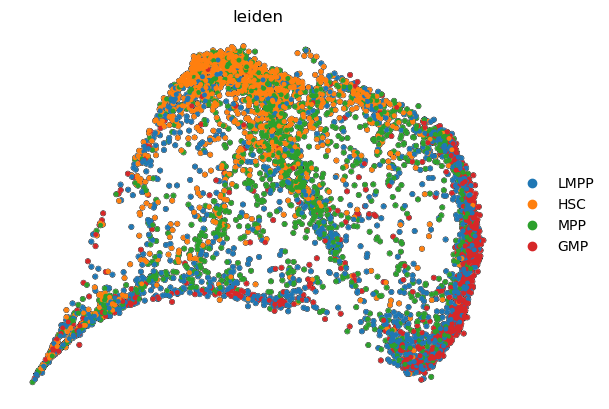

In [12]:
adata_mvi.obsm["latent"] = latent_acc
sc.pp.neighbors(adata_mvi, use_rep = 'latent', metric = 'manhattan')
sc.tl.umap(adata_mvi, min_dist=0.1, negative_sample_rate=0.05)

sc.pl.umap(adata_mvi, frameon=False, size = 50, alpha = 1, add_outline=True,
          outline_width=(0.1,0), color='leiden')

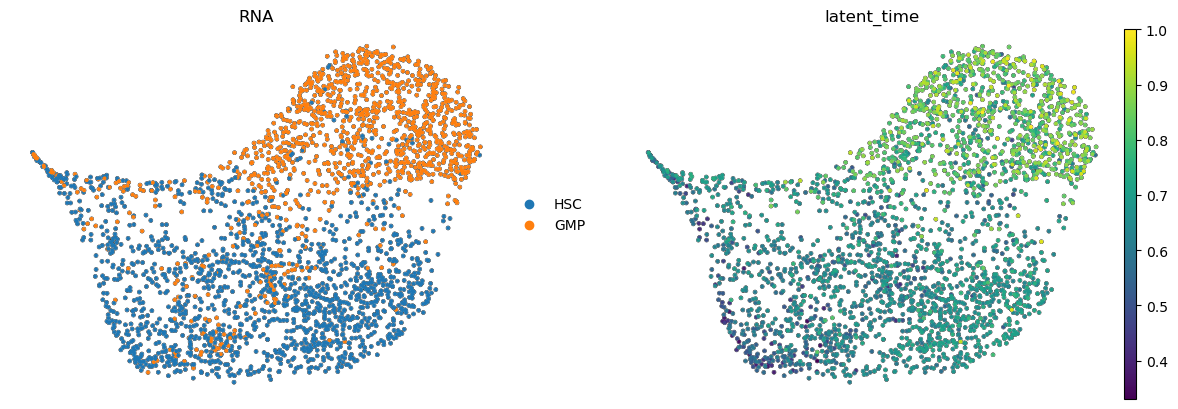

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns


adata_mvi.obsm["latent"] = latent_expr 
sc.pp.neighbors(adata_mvi, use_rep="latent", n_neighbors=25)


hsc_check = adata_mvi.obs['leiden'] == "HSC"
mpp_check = adata_mvi.obs['leiden'] == "MPP"
lmpp_check = adata_mvi.obs['leiden'] == "LMPP"
gmp_check = adata_mvi.obs['leiden'] == "GMP"

# myeloid_check = (hsc_check | mpp_check | lmpp_check | gmp_check)
myeloid_check = (hsc_check | gmp_check)

# myeloid_data = adata_mvi[myeloid_check, :]
myeloid_data = adata_mvi[myeloid_check, :]

# sc.pp.neighbors(myeloid_data, use_rep = 'latent', metric = 'manhattan')
sc.pp.neighbors(myeloid_data, use_rep = 'latent', metric = 'manhattan')

sc.tl.umap(myeloid_data, min_dist=0.5, negative_sample_rate=0.05)
# sc.tl.umap(myeloid_data, min_dist=0.1)

sc.pl.umap(myeloid_data, frameon=False, size = 30, alpha = 1, add_outline=True,
          outline_width=(0.1,0), color=['leiden', "latent_time"], title="RNA")

# sc.tl.louvain(adata_mvi)

%matplotlib inline

plt.show()

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


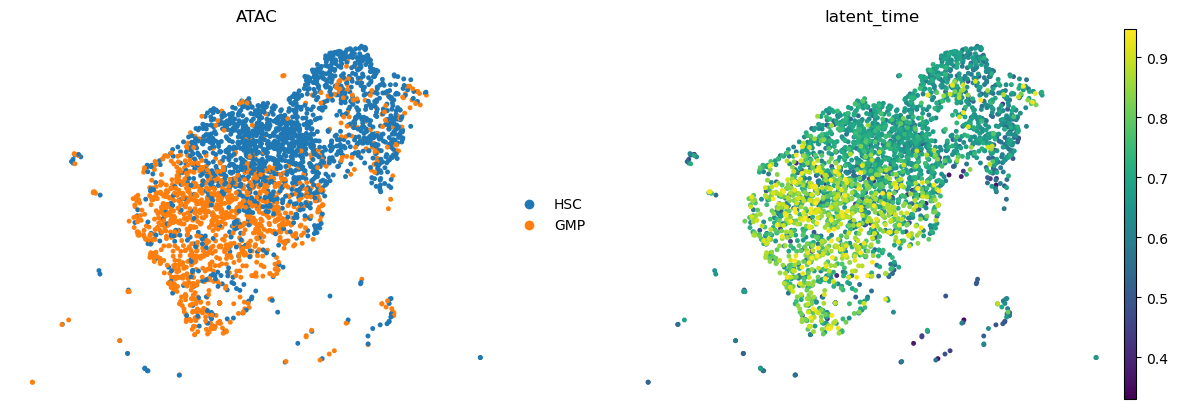

In [9]:
adata_mvi.obsm["latent"] = latent_acc

myeloid_data = adata_mvi[myeloid_check, :]

sc.pp.neighbors(adata_mvi, use_rep="latent", n_neighbors=25)
sc.tl.umap(myeloid_data,min_dist =0.5)

%matplotlib inline
# sc.pl.umap(myeloid_data, color=['celltype'])
sc.pl.umap(myeloid_data,color=['leiden', "latent_time"], s=50, frameon=False, ncols=2, vmax='p99', title="ATAC")

plt.show()

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


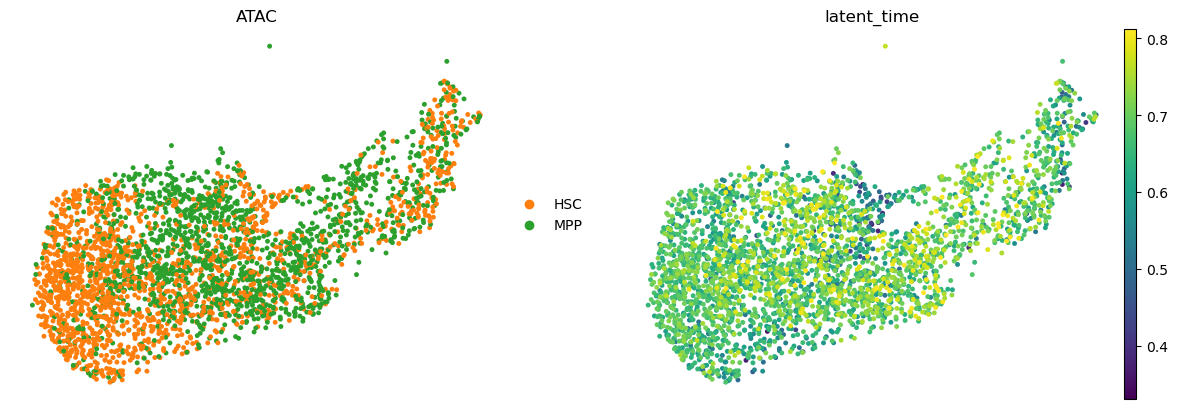

In [37]:
adata_mvi.obsm["latent"] = latent_acc + latent_expr
sc.pp.neighbors(adata_mvi, use_rep="latent", n_neighbors=25)
myeloid_data = adata_mvi[myeloid_check, :]


sc.tl.umap(myeloid_data,min_dist =0.5)

%matplotlib inline
# sc.pl.umap(myeloid_data, color=['celltype'])
sc.pl.umap(myeloid_data,color=['leiden', "latent_time"], s=50, frameon=False, ncols=2, vmax='p99', title="ATAC")

plt.show()

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


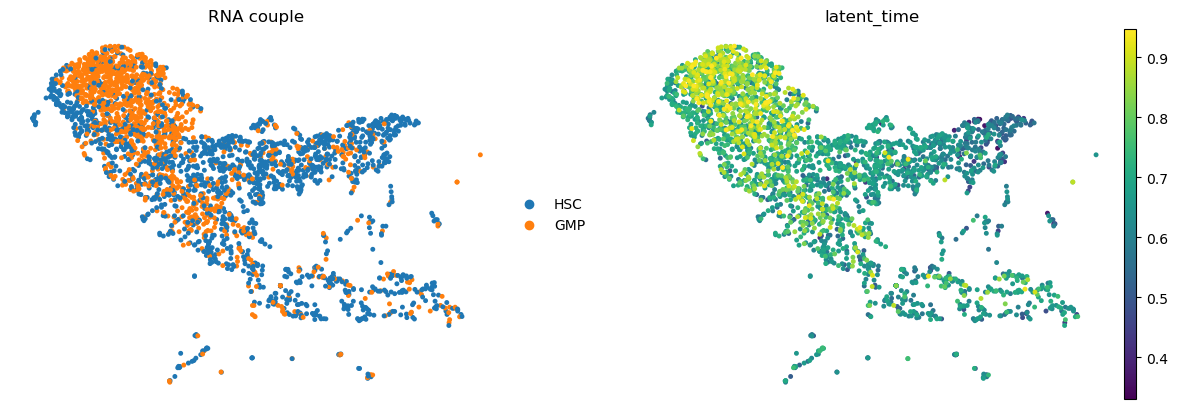

In [35]:
adata_mvi.obsm["latent"] =latent_expr_dep
sc.pp.neighbors(adata_mvi, use_rep="latent", n_neighbors=25)



myeloid_data = adata_mvi[myeloid_check, :]

sc.tl.umap(myeloid_data,min_dist =0.5)

%matplotlib inline
sc.pl.umap(myeloid_data,color=['leiden', "latent_time"], s=50, frameon=False, ncols=2, vmax='p99', title="RNA couple")


plt.show()

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


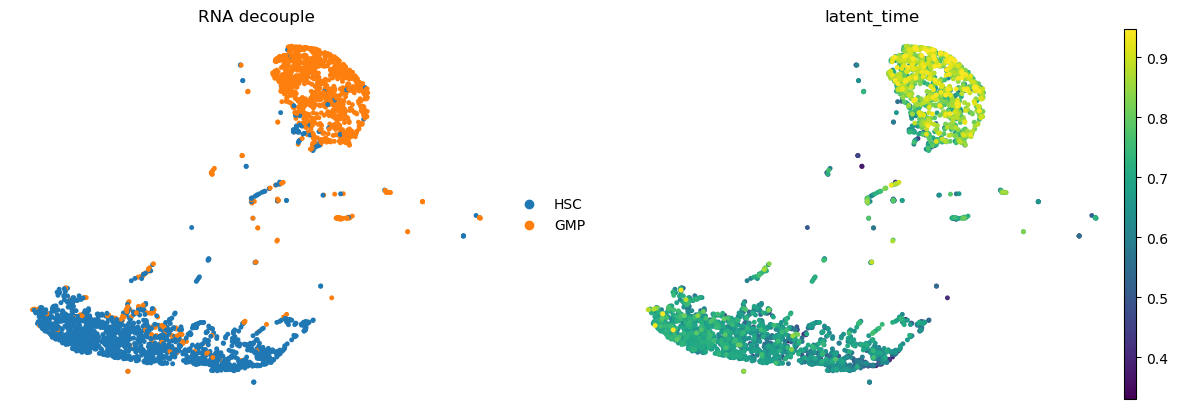

In [36]:
adata_mvi.obsm["latent"] =latent_expr_indep
sc.pp.neighbors(adata_mvi, use_rep="latent", n_neighbors=25)

# sc.tl.umap(adata_mvi,min_dist =0.5)

# %matplotlib inline
# # sc.pl.umap(adata_mvi, color=['celltype'])
# sc.pl.umap(adata_mvi,color=['leiden', "latent_time"], s=50, frameon=False, ncols=2, vmax='p99', title="ATAC")

myeloid_data = adata_mvi[myeloid_check, :]

sc.tl.umap(myeloid_data,min_dist =0.3)

%matplotlib inline
sc.pl.umap(myeloid_data,color=['leiden', "latent_time"], s=50, frameon=False, ncols=2, vmax='p99', title="RNA decouple")

plt.show()

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


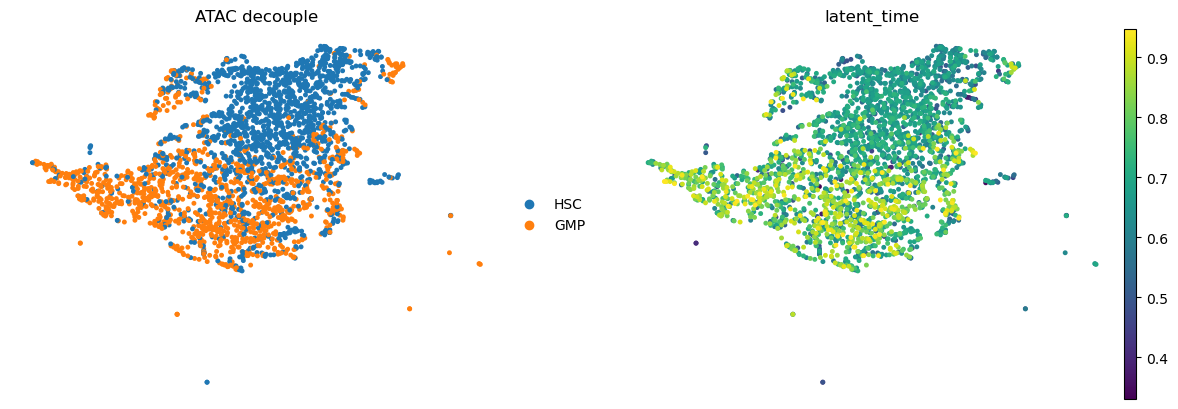

In [37]:
adata_mvi.obsm["latent"] =latent_atac_indep
sc.pp.neighbors(adata_mvi, use_rep="latent", n_neighbors=25)

# sc.tl.umap(adata_mvi,min_dist =0.5)

# %matplotlib inline
# # sc.pl.umap(adata_mvi, color=['celltype'])
# sc.pl.umap(adata_mvi,color=['leiden', "latent_time"], s=50, frameon=False, ncols=2, vmax='p99', title="ATAC")

myeloid_data = adata_mvi[myeloid_check, :]
sc.tl.umap(myeloid_data,min_dist =0.3)

%matplotlib inline
sc.pl.umap(myeloid_data,color=['leiden', "latent_time"], s=50, frameon=False, ncols=2, vmax='p99', title="ATAC decouple")


plt.show()

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


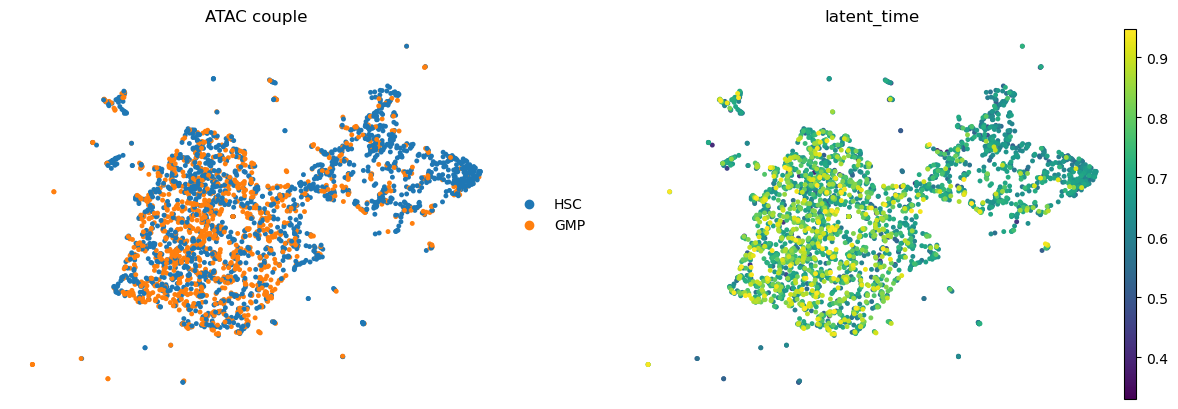

In [38]:
adata_mvi.obsm["latent"] =latent_atac_dep
sc.pp.neighbors(adata_mvi, use_rep="latent", n_neighbors=15)

# sc.tl.umap(adata_mvi,min_dist =0.5)

# %matplotlib inline
# # sc.pl.umap(adata_mvi, color=['celltype'])
# sc.pl.umap(adata_mvi,color=['leiden', "latent_time"], s=50, frameon=False, ncols=2, vmax='p99', title="ATAC")

myeloid_data = adata_mvi[myeloid_check, :]
sc.tl.umap(myeloid_data,min_dist =0.3)

%matplotlib inline
sc.pl.umap(myeloid_data,color=['leiden', "latent_time"], s=50, frameon=False, ncols=2, vmax='p99', title="ATAC couple")


plt.show()

In [14]:
# variables for subsetting the AnnData object to just the erythrocyte lineage
erythrocyte_check = adata_mvi.obs['leiden'] == "Erythrocyte"
mep_check = adata_mvi.obs['leiden'] == "MEP"
hsc_check = adata_mvi.obs['leiden'] == "HSC"
progdc_check = adata_mvi.obs['leiden'] == "ProgDC"
erythroid_check = (erythrocyte_check | mep_check | hsc_check | progdc_check)


/tmp/ipykernel_26939/3191557945.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  erythroid_data.obs["latent_time"] = 1 - erythroid_data.obs["latent_time"]


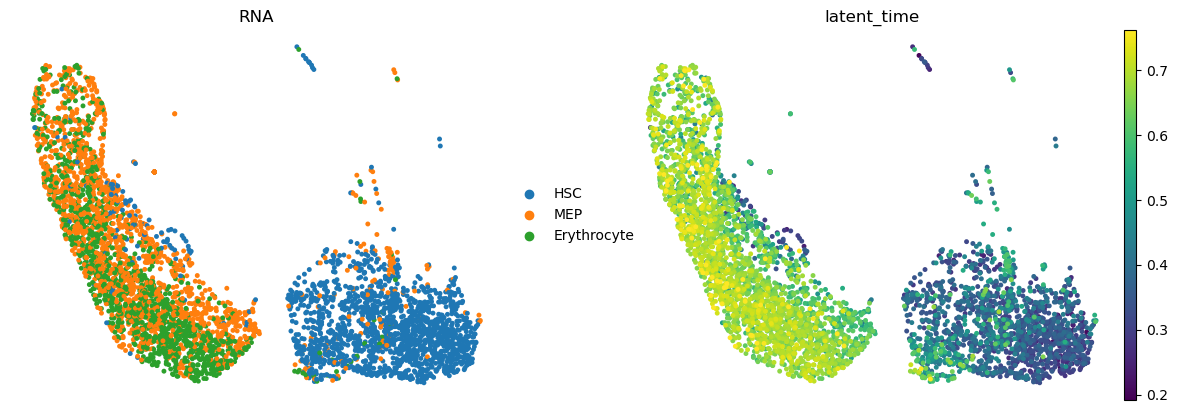

In [21]:
adata_mvi.obsm["latent"] = latent_expr
sc.pp.neighbors(adata_mvi, use_rep="latent", n_neighbors=25)
erythroid_data = adata_mvi[erythroid_check, :]
erythroid_data.obs["latent_time"] = 1 - erythroid_data.obs["latent_time"]

sc.tl.umap(erythroid_data,min_dist =0.5)

%matplotlib inline
# sc.pl.umap(myeloid_data, color=['celltype'])
sc.pl.umap(erythroid_data,color=['leiden', "latent_time"], s=50, frameon=False, ncols=2, vmax='p99', title="RNA")

plt.show()

/tmp/ipykernel_26939/3176052724.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  erythroid_data.obs["latent_time"] = 1 - erythroid_data.obs["latent_time"]


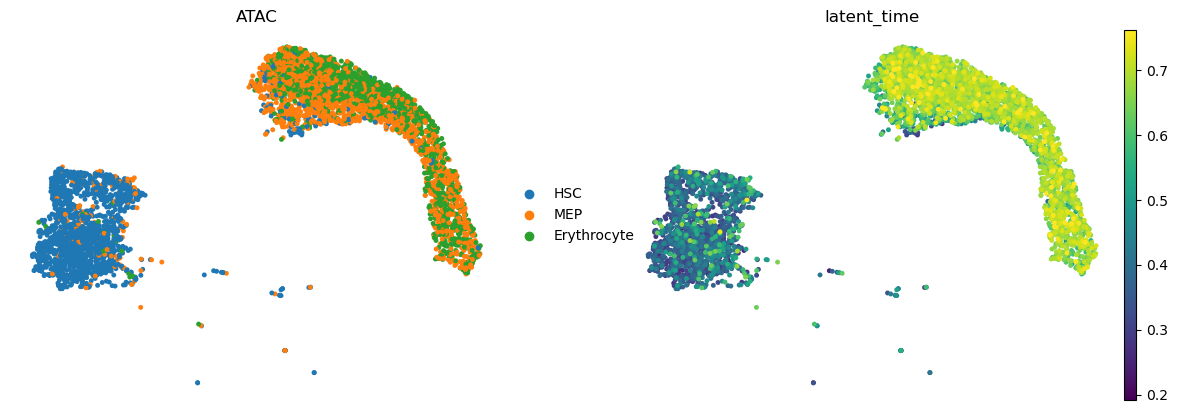

In [22]:
adata_mvi.obsm["latent"] = latent_acc
sc.pp.neighbors(adata_mvi, use_rep="latent", n_neighbors=25)
erythroid_data = adata_mvi[erythroid_check, :]
erythroid_data.obs["latent_time"] = 1 - erythroid_data.obs["latent_time"]

sc.tl.umap(erythroid_data,min_dist =0.5)

%matplotlib inline
# sc.pl.umap(myeloid_data, color=['celltype'])
sc.pl.umap(erythroid_data,color=['leiden', "latent_time"], s=50, frameon=False, ncols=2, vmax='p99', title="ATAC")

plt.show()

/tmp/ipykernel_26939/2217418661.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  erythroid_data.obs["latent_time"] = 1 - erythroid_data.obs["latent_time"]


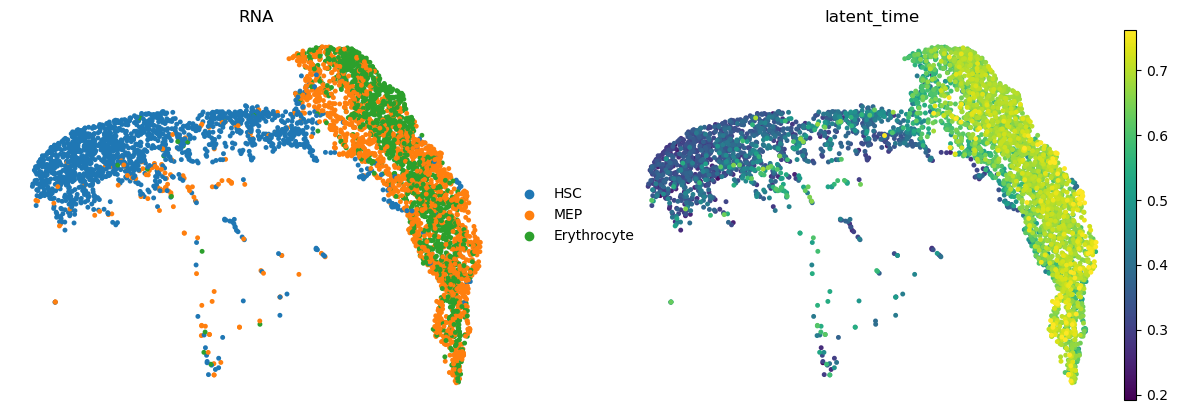

In [23]:
adata_mvi.obsm["latent"] = latent_expr_indep
sc.pp.neighbors(adata_mvi, use_rep="latent", n_neighbors=25)
erythroid_data = adata_mvi[erythroid_check, :]
erythroid_data.obs["latent_time"] = 1 - erythroid_data.obs["latent_time"]

sc.tl.umap(erythroid_data,min_dist =0.5)

%matplotlib inline
# sc.pl.umap(myeloid_data, color=['celltype'])
sc.pl.umap(erythroid_data,color=['leiden', "latent_time"], s=50, frameon=False, ncols=2, vmax='p99', title="RNA")

plt.show()

/tmp/ipykernel_26939/696083204.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  erythroid_data.obs["latent_time"] = 1 - erythroid_data.obs["latent_time"]


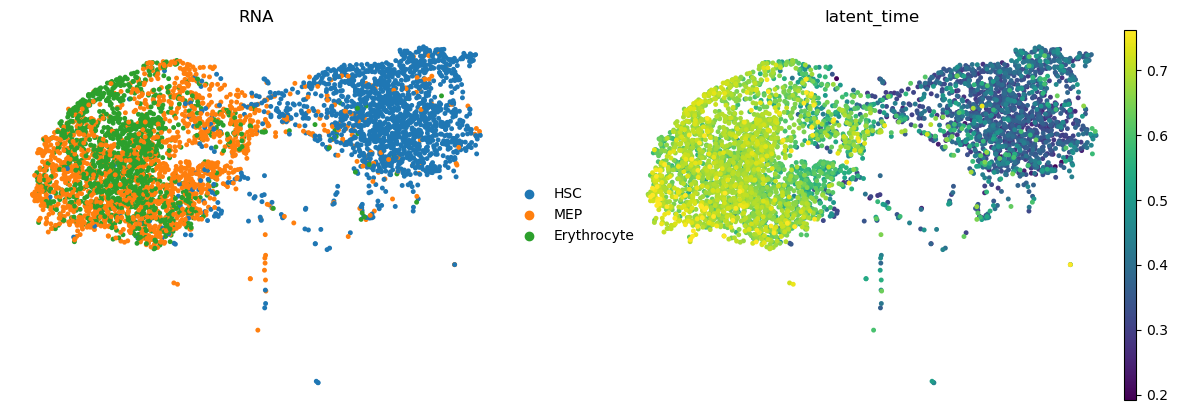

In [24]:
adata_mvi.obsm["latent"] = latent_atac_indep

sc.pp.neighbors(adata_mvi, use_rep="latent", n_neighbors=25)
erythroid_data = adata_mvi[erythroid_check, :]
erythroid_data.obs["latent_time"] = 1 - erythroid_data.obs["latent_time"]

sc.tl.umap(erythroid_data,min_dist =0.5)

%matplotlib inline
# sc.pl.umap(myeloid_data, color=['celltype'])
sc.pl.umap(erythroid_data,color=['leiden', "latent_time"], s=50, frameon=False, ncols=2, vmax='p99', title="RNA")

plt.show()

/tmp/ipykernel_26939/1272722068.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  erythroid_data.obs["latent_time"] = 1 - erythroid_data.obs["latent_time"]


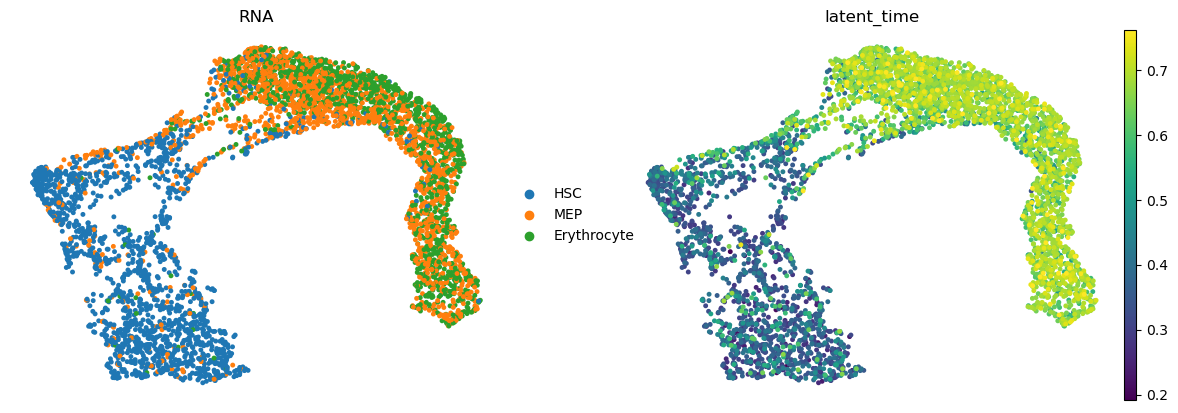

In [25]:
adata_mvi.obsm["latent"] = latent_atac_dep

sc.pp.neighbors(adata_mvi, use_rep="latent", n_neighbors=25)
erythroid_data = adata_mvi[erythroid_check, :]
erythroid_data.obs["latent_time"] = 1 - erythroid_data.obs["latent_time"]

sc.tl.umap(erythroid_data,min_dist =0.5)

%matplotlib inline
# sc.pl.umap(myeloid_data, color=['celltype'])
sc.pl.umap(erythroid_data,color=['leiden', "latent_time"], s=50, frameon=False, ncols=2, vmax='p99', title="RNA")

plt.show()

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


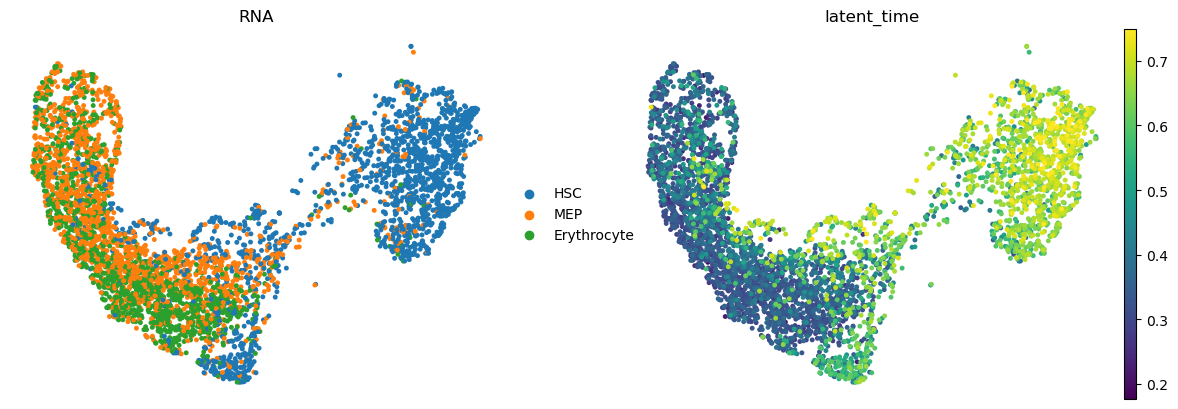

In [20]:
adata_mvi.obsm["latent"] = latent_expr_dep

sc.pp.neighbors(adata_mvi, use_rep="latent", n_neighbors=25)
erythroid_data = adata_mvi[erythroid_check, :]
erythroid_data.obs["latent_time"] = 1 - erythroid_data.obs["latent_time"]

sc.tl.umap(erythroid_data,min_dist =0.5)

%matplotlib inline
# sc.pl.umap(myeloid_data, color=['celltype'])
sc.pl.umap(erythroid_data,color=['leiden', "latent_time"], s=50, frameon=False, ncols=2, vmax='p99', title="RNA")

plt.show()

In [27]:
platelet_check = adata_mvi.obs['leiden'] == "Platelet"
progmk_check = adata_mvi.obs['leiden'] == "Prog MK"
mep_check = adata_mvi.obs['leiden'] == "MEP"

platelet_lineage_check = (platelet_check | progmk_check | mep_check | hsc_check)
# platelet_lineage_check = (platelet_check | progmk_check |mep_check)


/tmp/ipykernel_26939/2671237471.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  platelet_data.obs["latent_time"] = 1 - platelet_data.obs["latent_time"]


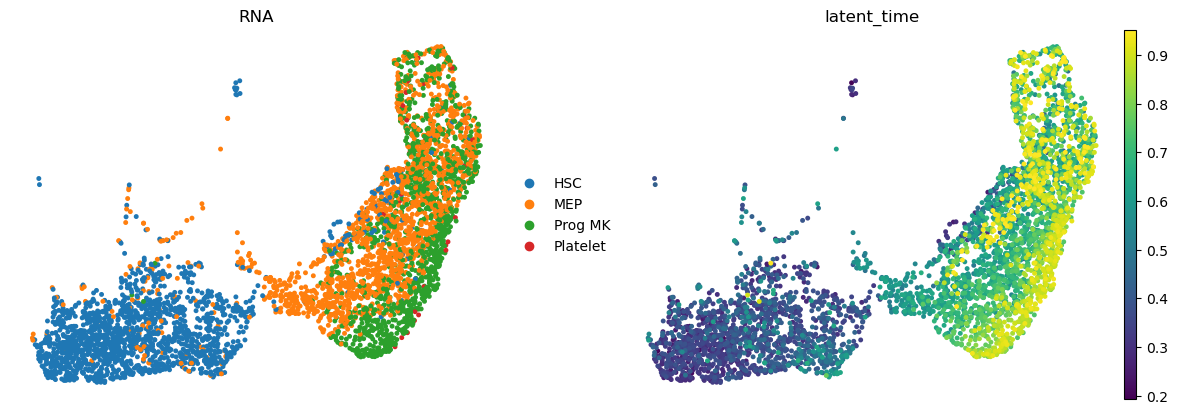

In [28]:
adata_mvi.obsm["latent"] = latent_expr
sc.pp.neighbors(adata_mvi, use_rep="latent", n_neighbors=25)
platelet_data = adata_mvi[platelet_lineage_check, :]
platelet_data.obs["latent_time"] = 1 - platelet_data.obs["latent_time"]

sc.tl.umap(platelet_data,min_dist =0.5)

%matplotlib inline
# sc.pl.umap(myeloid_data, color=['celltype'])
sc.pl.umap(platelet_data,color=['leiden', "latent_time"], s=50, frameon=False, ncols=2, vmax='p99', title="RNA")

plt.show()

/tmp/ipykernel_26939/2626268259.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  platelet_data.obs["latent_time"] = 1 - platelet_data.obs["latent_time"]


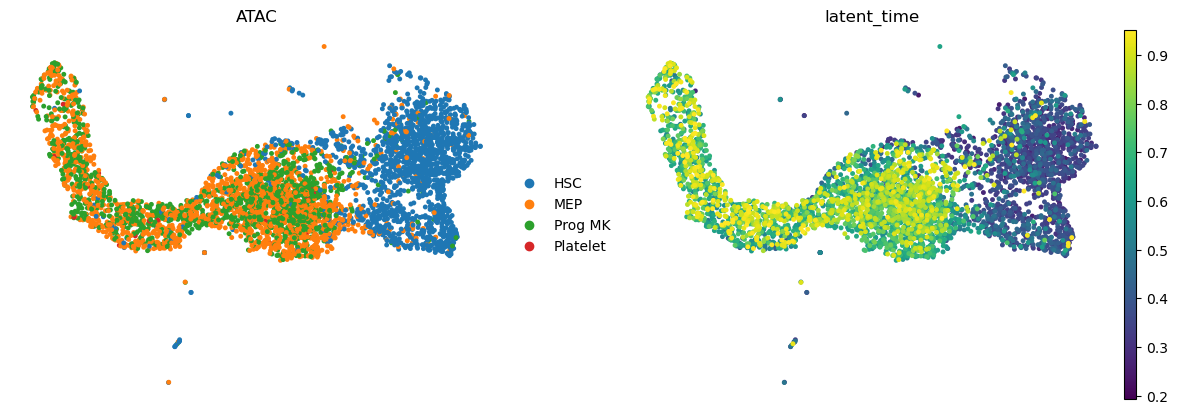

In [39]:
adata_mvi.obsm["latent"] = latent_acc
sc.pp.neighbors(adata_mvi, use_rep="latent", n_neighbors=25)
platelet_data = adata_mvi[platelet_lineage_check, :]
platelet_data.obs["latent_time"] = 1 - platelet_data.obs["latent_time"]

sc.tl.umap(platelet_data,min_dist =0.5)

%matplotlib inline
# sc.pl.umap(myeloid_data, color=['celltype'])
sc.pl.umap(platelet_data,color=['leiden', "latent_time"], s=50, frameon=False, ncols=2, vmax='p99', title="ATAC")

plt.show()

/tmp/ipykernel_26939/827165352.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  platelet_data.obs["latent_time"] = 1 - platelet_data.obs["latent_time"]


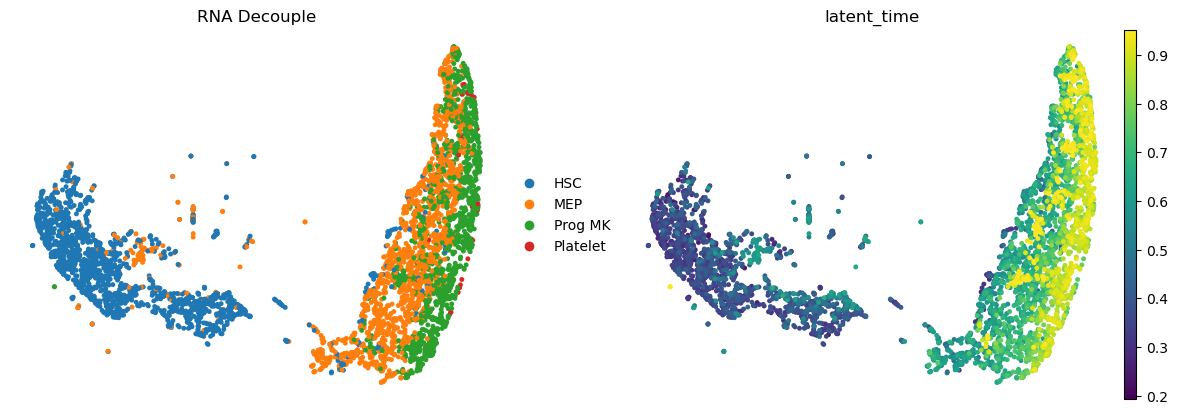

In [40]:
adata_mvi.obsm["latent"] = latent_expr_indep
sc.pp.neighbors(adata_mvi, use_rep="latent", n_neighbors=15)
platelet_data = adata_mvi[platelet_lineage_check, :]
platelet_data.obs["latent_time"] = 1 - platelet_data.obs["latent_time"]

sc.tl.umap(platelet_data,min_dist =0.3)

%matplotlib inline
# sc.pl.umap(myeloid_data, color=['celltype'])
sc.pl.umap(platelet_data,color=['leiden', "latent_time"], s=50, frameon=False, ncols=2, vmax='p99', title="RNA Decouple")

plt.show()

/tmp/ipykernel_26939/3608109453.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  platelet_data.obs["latent_time"] = 1 - platelet_data.obs["latent_time"]


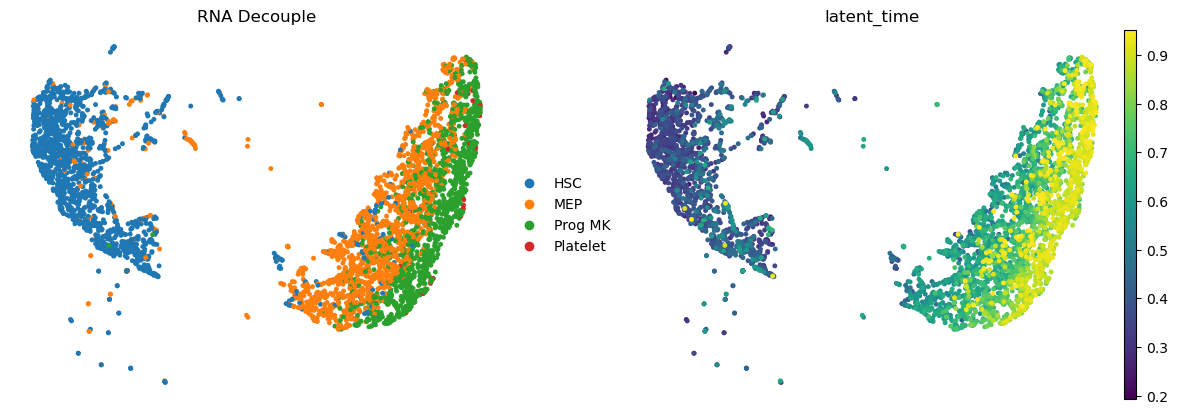

In [44]:
adata_mvi.obsm["latent"] = latent_expr_indep + latent_atac_indep
sc.pp.neighbors(adata_mvi, use_rep="latent", n_neighbors=15)
platelet_data = adata_mvi[platelet_lineage_check, :]
platelet_data.obs["latent_time"] = 1 - platelet_data.obs["latent_time"]

sc.tl.umap(platelet_data,min_dist =0.3)

%matplotlib inline
# sc.pl.umap(myeloid_data, color=['celltype'])
sc.pl.umap(platelet_data,color=['leiden', "latent_time"], s=50, frameon=False, ncols=2, vmax='p99', title="RNA Decouple")

plt.show()

/tmp/ipykernel_26939/3371014938.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  platelet_data.obs["latent_time"] = 1 - platelet_data.obs["latent_time"]


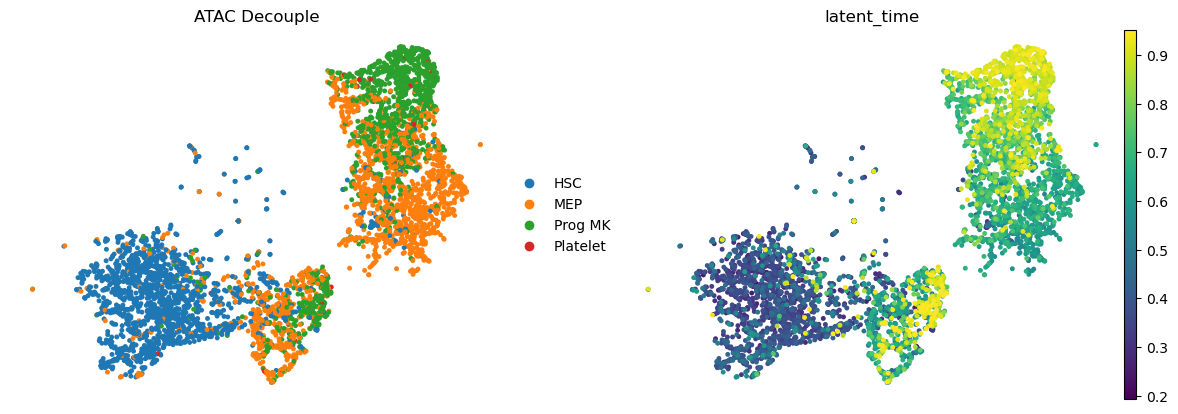

In [41]:
adata_mvi.obsm["latent"] = latent_atac_indep
sc.pp.neighbors(adata_mvi, use_rep="latent", n_neighbors=15)
platelet_data = adata_mvi[platelet_lineage_check, :]
platelet_data.obs["latent_time"] = 1 - platelet_data.obs["latent_time"]

sc.tl.umap(platelet_data,min_dist =0.3)

%matplotlib inline
# sc.pl.umap(myeloid_data, color=['celltype'])
sc.pl.umap(platelet_data,color=['leiden', "latent_time"], s=50, frameon=False, ncols=2, vmax='p99', title="ATAC Decouple")

plt.show()

/tmp/ipykernel_26939/829925647.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  platelet_data.obs["latent_time"] = 1 - platelet_data.obs["latent_time"]


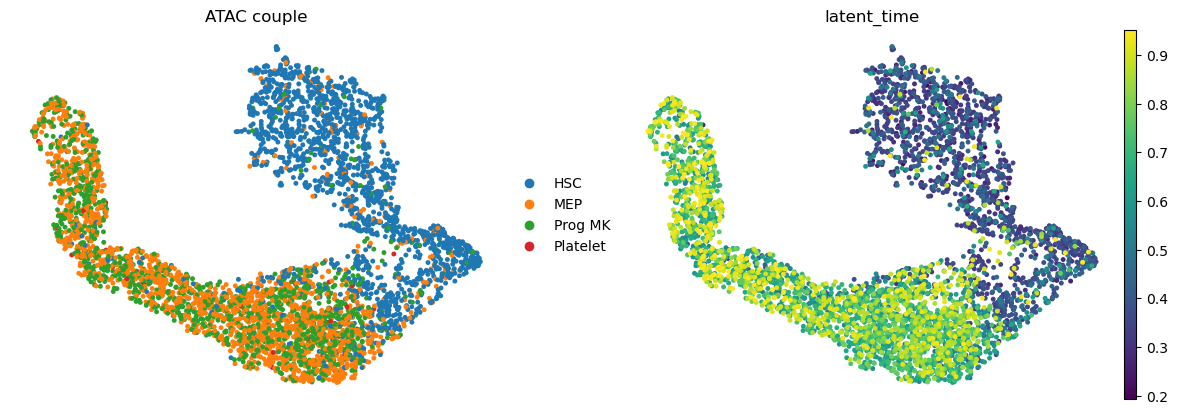

In [42]:
adata_mvi.obsm["latent"] = latent_atac_dep
sc.pp.neighbors(adata_mvi, use_rep="latent", n_neighbors=25)
platelet_data = adata_mvi[platelet_lineage_check, :]
platelet_data.obs["latent_time"] = 1 - platelet_data.obs["latent_time"]

sc.tl.umap(platelet_data,min_dist =0.5)

%matplotlib inline
# sc.pl.umap(myeloid_data, color=['celltype'])
sc.pl.umap(platelet_data,color=['leiden', "latent_time"], s=50, frameon=False, ncols=2, vmax='p99', title="ATAC couple")

plt.show()

/tmp/ipykernel_26939/1647540095.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  platelet_data.obs["latent_time"] = 1 - platelet_data.obs["latent_time"]


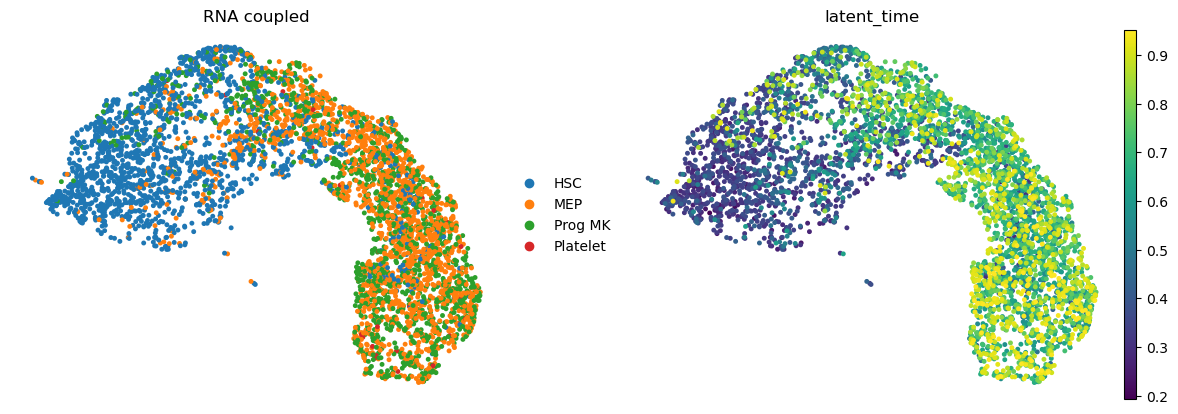

In [43]:
adata_mvi.obsm["latent"] = latent_expr_dep
sc.pp.neighbors(adata_mvi, use_rep="latent", n_neighbors=25)
platelet_data = adata_mvi[platelet_lineage_check, :]
platelet_data.obs["latent_time"] = 1 - platelet_data.obs["latent_time"]

sc.tl.umap(platelet_data,min_dist =0.5)

%matplotlib inline
# sc.pl.umap(myeloid_data, color=['celltype'])
sc.pl.umap(platelet_data,color=['leiden', "latent_time"], s=50, frameon=False, ncols=2, vmax='p99', title="RNA coupled")

plt.show()